In [1]:
!pip install fsspec --upgrade


     |████████████████████████████████| 85 kB 894 kB/s 
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.7.2
    Uninstalling fsspec-0.7.2:
      Successfully uninstalled fsspec-0.7.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

try:
    from kaggle_datasets import KaggleDatasets
    dataset_gcs = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
    print('got GCS path via KaggleDatasets .get_gcs_path method')
except ModuleNotFoundError:
    #hardcode path while testing locally
    dataset_gcs = 'gs://'


got GCS path via KaggleDatasets .get_gcs_path method


In [3]:
tf.__version__


'2.2.0'

In [4]:
params = {
    'batch_size' : 128,
    'img_size' : [299, 299],
    'epochs': 350
}


In [5]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
params['batch_size'] = params['batch_size'] * strategy.num_replicas_in_sync

In [7]:
# sub = pd.read_csv(dataset_gcs + '/sample_submission.csv')
# sub.head(1)
!pip install gcsfs

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
train_df = pd.read_csv(dataset_gcs + '/train.csv')
train_df.groupby('target').count() 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant
target,,,,,,,
0,32542,32542,32477,32474,32024,32542,32542
1,584,584,584,584,575,584,584


In [9]:
def decode_image_label(tfrec):
    '''
    function to decode an image and target label from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        label: tensor, integer, either 1 or 0
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
    label = features['target']
    
    return decoded_image, label
    


In [10]:
def decode_image(tfrec):
    '''
    function to decode an image from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        img_name: tensor, string, Id of the decoded image
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
    img_name = features['image_name']
    
    return decoded_image, img_name

In [11]:
def normalize_image_label(decoded_image, label):
    '''
    function to convert an image tensor values from 0 to 255 
    -> -1 to 1
    to be used when dealing with tfrecords containing labels
    
    args:
        decoded_image: tensor that is an image with values from 0 to 255
        label: tensor, target label
    
    returns: 
        image_tensor: tensor that is an image with values from -1 to 1
        label, same as input
    
    '''
    
    #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
    image_tensor = tf.expand_dims(decoded_image, 0)
    #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
    image_tensor = tf.gather(image_tensor, 0)

    #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
    image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

#     #convert tensor values to between 0 and 1 (0 to 255 -> 0 to 1)
#     image_tensor = (tf.cast(image_tensor, tf.float32) /255.0 )

    return image_tensor, label

In [12]:
# def normalize_image(decoded_image): not used -- can be removed
#     '''
#     function to convert an image tensor values from 0 to 255 
#     -> -1 to 1
    
#     args:
#         decoded_image: tensor that is an image with values from 0 to 255
    
#     returns: 
#         image_tensor: tensor that is an image with values from -1 to 1
    
#     '''
    
#     #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
#     image_tensor = tf.expand_dims(decoded_image, 0)
#     #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
#     image_tensor = tf.gather(image_tensor, 0)

#     #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
#     image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

#     return image_tensor

In [13]:
def random_flip(image, label):
    '''
    function to randomly flip images on the x and/or y axis
    
    args:
        image: tensor, an image
        label: tensor, target label
    
    returns: 
        image: tensor, same as input, but possibly flipped on x and/or y axis
        label, tensor, same as input
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [14]:
def get_train_ds(tfrecords, batch_size):
    '''
    function to create a ds pipeline from tfrecord files
    
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    '''
    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
          cache(). #need to remove cache while not usnig TPUs
          map(decode_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          repeat().
          shuffle(512).
          batch(batch_size,
               drop_remainder=True).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    

    
    return ds
    

In [15]:
def get_test_ds(tfrecords, batch_size):
    '''
    function to create a dataset for test data
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    
    '''

    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
#           cache(). #there is no reason to cache this ds -- it is only being read 1x
          map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
#           map(random_flip).
          batch(batch_size).
#                 drop_remainder=True).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    
    return ds
    ###come back to this

# model architecture

In [16]:
def set_of_layers(input_layer, 
                  filters_, 
                  kernal, 
                  strides_, 
                  dense=None, 
                  dense_activation=None,
                  dropout=None,
                  cnn_activation=None):
    '''
    function to add the following layers to a model:
    Conv2D, MaxPooling2D, BatchNormalization, LeadyReLU, Dense,
        Dropout

    args:
      input_layer : input layer to be fed into above layers
      filters_: int, number of filters in Conv2D layer
      kernal: int, kernal size in Conv2D layer
      strides_: int, stride size in MaxPooling2D layer
      dense: int, number of units in dense layer, default is None
          Will only add layer if value is passed
      dense_activation: str, activation function to pass into Dense layer
          default is None
      dropout: float, dropout percentage in Dropout layer, default is None
        must be less than 1.0. Will only add layer if value is passed 
      cnn_activation: tensorflow activation layer, default is None
          will only add layer is value is passed. Activation layer will be
          added after the BatchNormalization layer

    returns:
      x: model that is the same as the input_layer input plus above 
        layers added
        
        
    '''
    

    x = layers.Conv2D(filters_, (kernal, kernal), padding='same')(input_layer)
    x = layers.MaxPooling2D(strides_, strides_)(x)
    if cnn_activation:
        x = cnn_activation(x) #s/b layers.Relu()
    if dense:
        x = layers.Dense(dense, activation=dense_activation)(x) #s/b none
    if dropout:
        x = layers.Dropout(dropout)(x) #s/b 0.5


    return x



In [17]:
def deconv_set_of_layers(input_layer, 
                         filters_, 
                         kernal_, 
                         stride, 
                         dense=None, 
                         dense_activation=None, 
                         dropout=None,
                         cnn_activation=None):
    '''
    function to add the following layers to a model:
    Conv2DTranspose, BatchNormalization, LeadyReLU, Dense

    args:
      input_layer : input layer to be fed into above layers
      filters_: int, number of filters in Conv2DTranspose layer
      kernal_: int, kernal size in Conv2DTranspose layer
      strides_: int, stride size in Conv2DTranspose layer
      dense: int, number of units in dense layer, default is None
          Will only add layer if value is passed
      dense_activation: str, activation function to pass into Dense layer
          default is None
      dropout: float, dropout percentage in Dropout layer, default is None
        must be less than 1.0. Will only add layer if value is passed 
      cnn_activation: tensorflow activation layer, default is None
          will only add layer is value is passed. Activation layer will be
          added after the BatchNormalization layer


    returns:
      x: model that is the same as the input_layer input plus above 
        layers added
    '''
    
    x = layers.Conv2DTranspose(filters_,
                              kernal_,
                              (stride, stride),
                              padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    if dense:
        x = layers.Dense(dense, activation=dense_activation)(x) #s/b 16, tanh
    if dropout:
        x = layers.Dropout(dropout)(x) #s/b 0.5

        
    return x


In [18]:
def xfer_learning_layers(input_tensor,
                         model,
                         input_shape,
                         end_of_model,
                         dense,
                         bias=None
                        ):
    '''
    function to create set of layers for transfer learning as follows:
    input_tensor -> pre-trained model(model) -> end_of_model ->
        dense layer -> dense prediction layer
    
    args:
        input_tensor, tensor, layer that will preceed the pre-trained model
        model, tf.keras.applications fn (without the '()'), pre-trained model
            whose architecture and weights will be used
        end_of_model, keras.Layer layer that will be the end of the pre-trained model
        input_shape, tuple (w, h, channels), shape of input being fed into model
        dense, int, number of dense nodes in a layer after end_of_model, and before
            prediction layer
        bias, array, shaped (1,), bias of prediction layer, default is None
        
    returns:
        x: set of layers as described above
    '''
    
    x = model(include_top=False,
             input_shape=input_shape,
             classes=1)(input_tensor)
    x = end_of_model(x)
    x = layers.Dense(dense)(x)
    x = layers.Dense(1, activation='sigmoid', bias_initializer=bias)(x)
    
    return x
    

In [19]:
def create_model(input_shape=[*params['img_size'], 3], bias_output=None):
    '''
    function to create a model that will be used to train DS via xfer learning
    
    args:
        input_shape: array, shape of input tensor that will be fed into model
    
    returns:
        model: keras.Model() model
    
    '''
    
    input_tensor = layers.Input(shape=input_shape, name='images_input')
    GblAvgPool = layers.GlobalAveragePooling2D()
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
    
#     # #input s/b 224, 224, 3 // try to normalize 0 -> 1
#     densenet_fn = tf.keras.applications.DenseNet121
#     densenet = xfer_learning_layers(input_tensor, 
#                                     densenet_fn, 
#                                     input_shape,
#                                     GblAvgPool,
#                                     512,
#                                     bias_output
#                                    )
#     ###end of densenet### auc - 0.8844 (-1 -> 1) auc 0.8967 (0 -> 1)
    
    # #s/b 224, 224, 3 // 
    # efficientnet = tf.keras.applications.EfficientNetB0(include_top=False,
    #                                                    input_shape=input_shape,
    #                                                    classes=1)(input_tensor)
    # end_of_efficientnet = layers.GlobalAveragePooling2D()(efficientnet)
    # dense_layers = layers.Dense(8)(end_of_efficientnet)
    # ###end of efficientnet### auc - 0.8602 (-1 -> 1)


    
    #s/b 299, 299, 3 // needs to be -1 --> 1
    xception_fn = tf.keras.applications.Xception
    xception = xfer_learning_layers(input_tensor,
                                   xception_fn,
                                   input_shape,
                                   GblAvgPool,
                                   8,
                                   bias_output)
    ###end of xception### auc - 0.9058 (2nd best)
    
    #s/b 299, 299, 3 // needs to be -1 -> 1
    inception_fn = tf.keras.applications.InceptionV3
    inception = xfer_learning_layers(input_tensor,
                                    inception_fn,
                                    input_shape,
                                    GblAvgPool,
                                    8,
                                    bias_output)
    ##end of inception (2016)### auc - 0.9009 (best)
    
#     #s/b 299, 299, 3 // needs to be -1 -> 1
#     inception_v2 = tf.keras.applications.InceptionResNetV2(include_top=False,
#                                                           input_shape=input_shape,
#                                                           classes=1)(input_tensor)
#     end_of_inceptionv2 = layers.GlobalAveragePooling2D()(inception_v2)
#     dense_layers = layers.Dense(8)(end_of_inceptionv2)
#     ###end of inception (2017)###
    
    #s/b 224, 224, 3 // needs to be -1 -> 1
    # mobilnet = tf.keras.applications.MobileNet(include_top=False,
    #                                           input_shape=input_shape,
    #                                           classes=1)(input_tensor)
    # end_of_mobilnet = layers.GlobalAveragePooling2D() (mobilnet)
    # dense_layers = layers.Dense(8)(end_of_mobilnet)
    ###end of mobilnet (v1)### auc - 0.8681

    # # s/b 224, 224, 3 // needs to be -1 --> 1
    # mobilnet_v2 = tf.keras.applications.MobileNetV2(include_top=False,
    #                                                input_shape=input_shape,
    #                                                classes=1)(input_tensor)
    # end_of_mobilnet_v2 = layers.GlobalAveragePooling2D()(mobilnet_v2)
    # dense_layers = layers.Dense(8)(end_of_mobilnet_v2)
    # ###end of mobilnet (2018)### #dont use -- immediately overfits training data




    



    x = layers.Concatenate()([xception, inception])
    x = layers.Dense(8)(x)

    output = layers.Dense(1, activation='sigmoid', bias_initializer=bias_output)(x)
    model = keras.Model(inputs=input_tensor, outputs=output)
    
    
    metrics = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = None
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
        metrics=metrics)
    
    
    return model

In [20]:
def create_model_obsol(input_shape=[*params['img_size'], 3], bias_output=None):
    '''
    function to create a model that will be trained on train DS
    
    args:
        input_shape: array, default: [1024, 1024, 3], shape
            of input tensor that will be fed into model
    
    returns:
        model: keras.Model() model
    '''

    relu = layers.ReLU()
    leakyrelu = layers.LeakyReLU()
    input_tensor = layers.Input(shape=input_shape, name='images_input')
    x = input_tensor
#     filters_list = [64, 128, 256, 512, 1024]
    filters_list = [32, 64, 128, 256, 512]
    
    for filter_ in filters_list:
        x = set_of_layers(x, filter_, [3, 5], 2, 16,  dropout=0.35, dense_activation='tanh', 
                           cnn_activation=relu)
        
    
    output_helper_1 = layers.Flatten(name='flatten_output_helper_1')(x)
    output_helper_1 = layers.Dense(128)(output_helper_1)
    
    
    
#     filters_list = [1024, 512, 256]
    filters_list = [512, 256, 128]
    
    for filter_ in filters_list:
        x = deconv_set_of_layers(x, filter_, [2, 4], 2, 16,  dense_activation='tanh', cnn_activation=relu,
                                 dropout=0.35)
    
    output_helper_2 = layers.Flatten(name='flatten_output_helper_2')(x)
    output_helper_2 = layers.Dense(128)(output_helper_2)

    
#     filters_list = [256, 512, 1024]
    filters_list = [128, 256, 512]
    
    for filter_ in filters_list:
        x = set_of_layers(x, filter_, [3, 5], 2, 16,  dropout=0.35, dense_activation='tanh',
                           cnn_activation=relu)



    x = layers.Flatten(name='flatten_main_output')(x)
    x = layers.Dense(128)(x)
#     model.add(layers.Dense(64))
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
    output_layer = layers.Dense(1, activation='sigmoid', bias_initializer=bias_output)(x)
    
    output_helper_1 = layers.Dense(1, activation='sigmoid',
                                  bias_initializer=bias_output)(output_helper_1)
    output_helper_2 = layers.Dense(1, activation='sigmoid',
                                  bias_initializer=bias_output)(output_helper_2)
    
    model=keras.Model(inputs=[input_tensor],
                     outputs=[output_layer, output_helper_1, output_helper_2])

 
           
    metrics = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = None
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.00033),
        loss = [tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
                tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
                tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01)],
        metrics=metrics,
    loss_weights = [1.0, 0.15, 0.15])
    

    
    return model



In [21]:
def get_ds_size(files):
    '''
    function to get size of tfrecord Dataset, based on file name
    
    the file name has the number of records in the file, for example:
    train09-2071.tfrec has 2017 records
    
    args:
        files: list of str file names, each item should be the path to a tfrecord file
    
    returns:
        size: int, size of dataset
    '''
    size = 0
    for file in files:
        file_size = int(file.split('.tfrec')[0].split('tfrecords/')[1].split('-')[1])
        size += file_size
    return size

In [22]:
#get test file paths
test_files = tf.io.gfile.glob(dataset_gcs + '/tfrecords/test*.tfrec')

#get train and validation file paths
train_files, valid_files = train_test_split(tf.io.gfile.glob(dataset_gcs + '/tfrecords/train*.tfrec'),
                              test_size=.1, random_state=1)

#create datasets
train_ds = get_train_ds(train_files, params['batch_size'])
valid_ds = get_train_ds(valid_files, params['batch_size'])
test_ds = get_test_ds(test_files, params['batch_size'])

In [23]:
train_size, valid_size = get_ds_size(train_files), get_ds_size(valid_files)
test_size = get_ds_size(test_files)
print('the dataset consists of: {} training images, {} validation images, and {} test images'.
     format(train_size, valid_size, test_size))

the dataset consists of: 28984 training images, 4142 validation images, and 10982 test images


In [24]:
epoch_steps = train_size / params['batch_size'] 
valid_steps = valid_size / params['batch_size']
test_steps = 1.0 * test_size / params['batch_size'] 

In [25]:
#calculate class weights

targets = train_df.groupby('target').count()['diagnosis'].to_list()
target_0 = targets[0]
target_1 = targets[1]
total = target_0 + target_1

class_weight_0 = (1 / target_0) * (total) / 2.0
class_weight_1 = (1 / target_1) * (total) / 2.0

class_weights = {0: class_weight_0, 1: class_weight_1}

initial_bias = np.log([target_1 / target_0])



In [26]:
def lr_schedule_fn(epoch, lr):
    if epoch < 8:
        return 0.000001
    elif epoch == 8:
        return 0.0003
    elif epoch %2 ==0 and epoch < 69:
        return lr * 0.85
    else:
        return lr

In [27]:
with strategy.scope():
    model = create_model(bias_output=None)
    model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images_input (InputLayer)       [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    images_input[0][0]               
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    images_input[0][0]               
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
                             

# Training

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', #val_auc
                                patience=35,
                                mode='max',
                                restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule_fn)


history = model.fit(
    train_ds,
#     batch_size=params['batch_size'],
    epochs= params['epochs'], 
    steps_per_epoch=epoch_steps,
    validation_data=valid_ds,
    validation_steps=valid_steps,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_schedule]
)



Epoch 1/350
29/28 [==============================] - 63s 2s/step - auc: 0.5520 - tp: 524.0000 - fn: 0.0000e+00 - loss: 0.8928 - accuracy: 0.0176 - val_auc: 0.5428 - val_tp: 84.0000 - val_fn: 0.0000e+00 - val_loss: 1.4905 - val_accuracy: 0.0164 - lr: 1.0000e-06
Epoch 2/350
29/28 [==============================] - 38s 1s/step - auc: 0.6035 - tp: 526.0000 - fn: 0.0000e+00 - loss: 0.8876 - accuracy: 0.0177 - val_auc: 0.5834 - val_tp: 87.0000 - val_fn: 0.0000e+00 - val_loss: 1.4643 - val_accuracy: 0.0170 - lr: 1.0000e-06
Epoch 3/350
29/28 [==============================] - 35s 1s/step - auc: 0.6516 - tp: 529.0000 - fn: 0.0000e+00 - loss: 0.8827 - accuracy: 0.0178 - val_auc: 0.5698 - val_tp: 87.0000 - val_fn: 0.0000e+00 - val_loss: 1.4422 - val_accuracy: 0.0170 - lr: 1.0000e-06
Epoch 4/350
29/28 [==============================] - 38s 1s/step - auc: 0.6944 - tp: 527.0000 - fn: 0.0000e+00 - loss: 0.8765 - accuracy: 0.0177 - val_auc: 0.6094 - val_tp: 86.0000 - val_fn: 0.0000e+00 - val_loss: 1.4

In [29]:
predictions = model.predict(test_ds.map(lambda img, igs: img), steps=test_steps)  

In [30]:
prediction_ids = next(iter(test_ds.
                          map(lambda img, ids:ids).
                          unbatch().
                          batch(test_size))).numpy().astype('str')

Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [31]:
prediction_dict = {
    'image_name': prediction_ids,
    'target': np.concatenate(predictions)
}
submission_ds = pd.DataFrame(prediction_dict)

In [32]:
submission_ds.head()

,image_name,target
0,ISIC_6381819,0.815493
1,ISIC_5583376,0.601476
2,ISIC_6408546,0.601476
3,ISIC_6932354,0.601478
4,ISIC_8191278,0.601477


In [33]:
submission_ds.to_csv('submission.csv', index=False)

# Metrics

In [34]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

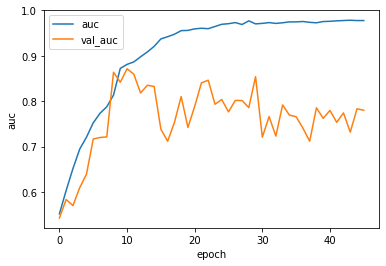

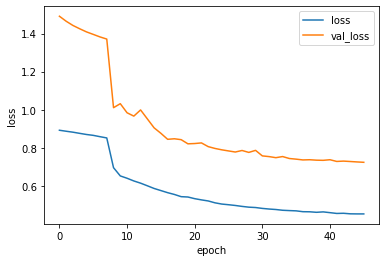

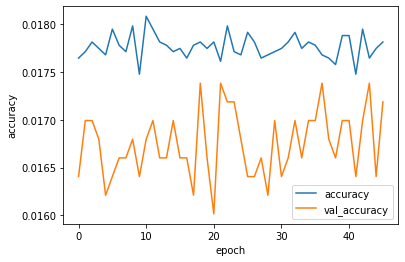

In [35]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [36]:
history.history

{'auc': [0.5519592761993408,
  0.6034871339797974,
  0.6515713334083557,
  0.6944467425346375,
  0.7207053303718567,
  0.7523835301399231,
  0.7733964323997498,
  0.7876133322715759,
  0.8135900497436523,
  0.8723440170288086,
  0.8811525702476501,
  0.8866137266159058,
  0.8979663252830505,
  0.9086024165153503,
  0.9208170771598816,
  0.937260627746582,
  0.9421738386154175,
  0.9475752711296082,
  0.9555260539054871,
  0.956043004989624,
  0.9594634771347046,
  0.9607964754104614,
  0.9598474502563477,
  0.9646613001823425,
  0.969525933265686,
  0.9708380103111267,
  0.9733035564422607,
  0.9690686464309692,
  0.9771106243133545,
  0.9704310297966003,
  0.9715354442596436,
  0.9732648730278015,
  0.9714673161506653,
  0.9728734493255615,
  0.9748080968856812,
  0.9748367667198181,
  0.9756808280944824,
  0.9738290905952454,
  0.9728285074234009,
  0.9755961894989014,
  0.9761260747909546,
  0.9771440029144287,
  0.9778311252593994,
  0.978450357913971,
  0.9777535796165466,
  0.977

In [37]:
model.save('model.h5')